#  A different kind of Dynamic Programming: Value Iteration.

- Dynamic Programming: We know all there is to know about the model and we want to find the optimal policy.
- Iterative Process: Starting from a random guess for the values, we use the Bellman Operator, and exploit the fact that it is _contracting_.

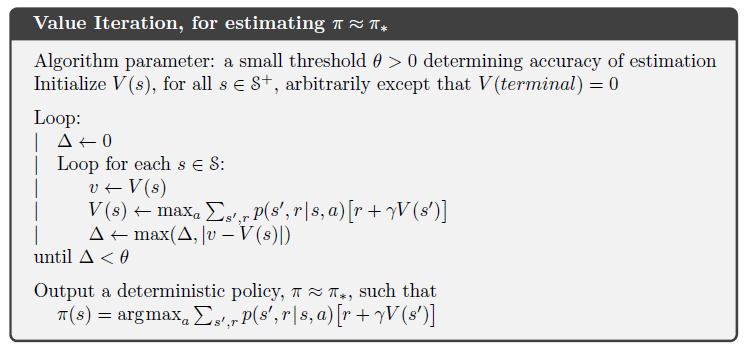


The next approximation of the values ($v_{k+1}(S)$) is the Bellman Operator applied to the current approximation ($v_k(S)$). 

This does not require us to be able to construct hierarchical 

__Q__: Is there a "proper" ordering for selecting the states to update? 

# The GridWorld Environment in Episodic tasks:

A square-cell worlds (... a grid), where an agent learns to find the optimal path from an initial state S to one or more goal states. 

Once it arrives to a goal state it gets a reward R and it _stops moving_: Goals are terminal states!

The agent can try and move up, down, left, right _but_ 

1) certain sites are blocked 

2) the agents cannot go outside the initial perimeter. If the agent tries to do forbidden moves, it stays still.



In [5]:
import numpy as np
# TYPICAL (GRID)WORLD


def new_world(Lx, Ly, Nblocks, goal, rewards):
    """
    Construct a gridworld of width Lx and height Ly, 
    with a number of blocks Nblocks (to be distributed randomly)
    and a list of tuple for positions of goal, and a list of corresponding rewards 
    """
    
    # Checks that the number of goals is consistent with the number of rewards
    assert len(goal) == len(rewards)
    
    # Constructs the empty matrix
    World = np.zeros((Ly,Lx))
    
    # Fills the empty matrix with random positions of blocks
    i_block = 0
    while (i_block < Nblocks): 
        blockX = np.random.randint(Lx)
        blockY = np.random.randint(Ly)
    
        # Checks wether the block was in the position of a goal
        if (((blockY, blockX) in goal) == False) :
            World[blockY, blockX] = -1
            i_block += 1
    
    # For all pairs of goals and rewards
    for g, r in zip(goal, rewards):
        World[g] = r
    return World


Visual representation of the gridworld:


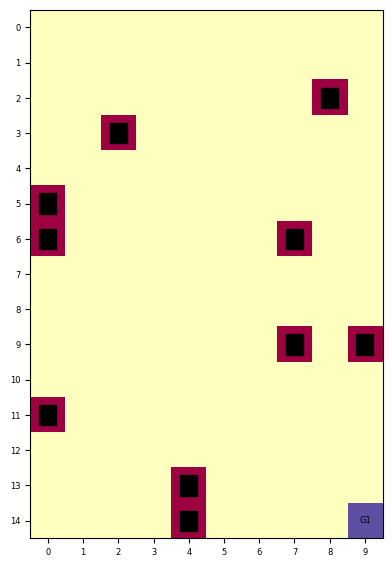

Matrix representation of the gridworld: 
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  1.]]


In [6]:
# Just a new gridworld to see how it works

Lx = 10
Ly = 15
Nblocks=10
goal = [(Ly-1,Lx-1)]
rewards = [1]

World = new_world(Lx, Ly, Nblocks, goal, rewards)

print("Visual representation of the gridworld:")
plot_world(World)

print("Matrix representation of the gridworld: ")
print(World)

# GridWorld as an MDP:

__State__ S: Position S=(i,j)

__Action__ A: Discrete. Up, Down, Left, Right     [ A=((+1,0), (-1,0), (0, -1), (0, +1)) ]

__Transition__ p: Deterministic.

p(S' | S, A) = 
- 1  _if    S' == S+A     and S' is allowed_
- 0  _else_

__Reward__ R: Only in reaching goal (=terminal state!): 0 everywhere, R when it moves _into_ a Goal state.
      


# Transition and Rewards

 - Transitions: Given a state S and the Action A, we return the new state, taking care that we do not do forbidden actions.

 - Rewards: Given a state S and the Action A and the new state S', we also have the probability to receive a reward R.

__PS: Achtung!__
The convention for python arrays is $A[i_y, i_x]$, where $i_y$ is the row-index and $i_x$ is the column-index... So the convention with _up_, _down_, _right_ and _left_ directions consistent, but may be a bit confusing: Use special care!

In [7]:
# The list of actions I can take: Actions = [Up, Down, Right, Left]
Actions = np.array([[1,0],[-1,0],[0,1],[0,-1]])

def p_transition_deterministic(S, A, World):
    """
    Takes the current position S and selected action A,
    and returns the resulting new S given a world World.
    To be consistent with the stochastic cases, it returns a list of possible new states S_new_list,
    alongside the relative probabilities P_list
    """
    # I try to move
    S_new = S + A
    Ly, Lx = World.shape
    # if I go out of the world, I stay still
    if ((S_new[0] == Ly) or np.any(S_new == -1) or (S_new[1] == Lx)):
        S_new = S
    # if I found a block I stay still
    elif World[S_new[0],S_new[1]] == -1:
        S_new = S
    # returns the new state
    S_new_list = [S_new]
    P_list = [1.0]
    return S_new_list, P_list 

def rewards(S, A, S_new, World):
    """
    Takes the current position S and selected action A,
    and returns the resulting reward given that it has ended up in S_new and 
    the gridwolrd is World.
    """
    # reward is always zero...
    reward = 0
    # expect when I reach the final goal
    if (World[S_new[0], S_new[1]] > 0) or (World[S_new[0], S_new[1]] < -1):
        reward = World[S_new[0], S_new[1]]
    # return the reward
    return reward


# Bellman Operator code: one-step update.

We are now going to code a single update of the Bellman Operation.


In [8]:
def update_values(Values, World, gamma, random_flag = False, p=0.9):
    """
    Takes the current matrix of values (V_k(s) )
    The associated gridworld,
    And computes the bellman operator   
    V_(k+1) (s) = max_a { sum_s'r   p(r, s'| s, a)(r + gamma V_k(s') }
    And the relative best policy
    pi_(k+1)(s) = argmax_a { sum_s'r   p(r, s'| s, a)(r + gamma V_k(s') }
    
    In the case with deterministic (p=1) or stochastic (p<1) actions.
    Returns V_(k+1)(s) and pi_(k+1)(s)
    """
    
    # -----------------------------------------------------------
    # The dimension of the world
    Ly, Lx = World.shape
    # initialize the vectors to store the new values and policy
    NewValues = np.zeros((Ly,Lx))
    NewPolicy = np.zeros((Ly,Lx,2))
    # 
    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    
    # what kind of transition do we have
    if random_flag:
        p_transition = p_transition_random_wrapper(p=p)
    else:
        p_transition = p_transition_deterministic
    # ------------------------------------------------------------
    
    # --------------- UPDATE -------------------------------------
    # cycle over all the states
    for ix in range(Lx):
        for iy in range(Ly):
            # state is defined by its indices
            S = np.array([iy, ix])
            
            # skip blocked squares
            if World[S[0],S[1]] != -1:
                maxvalue = -100
                
                # it "tries out" all actions and store the best
                for A in Actions:
                    
                    S_new_list, P_list = p_transition(S, A, World)
                    value_action = 0.0
                    for S_new, P in zip(S_new_list, P_list):
                        R = rewards(S, A, S_new, World)
                        value_action += P * (R + gamma*Values[S_new[0],S_new[1]])
                    
                    if (value_action > maxvalue):
                        maxvalue = value_action
                        bestact = A
                    # -------------------------
                    # Q: What happens in a tie?
                    # -------------------------

                # It stores the new value and policy of state S
                NewValues[S[0],S[1]] = maxvalue
                NewPolicy[S[0],S[1],:] = bestact
    # --------------------------------------------------------------

    # --------------------------------------------------------------
    for gx, gy in zip(goal[0],goal[1]):
        NewValues[gx, gy] = 0
        NewPolicy[gx, gy] = [0,0]
    # --------------------------------------------------------------
    return NewValues, NewPolicy

# Example I: One Goal.

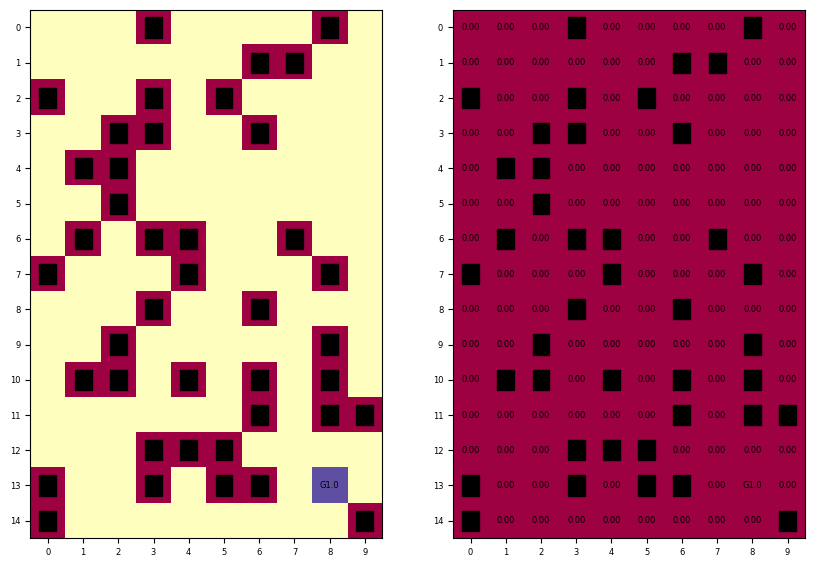

In [9]:
Lx = 10
Ly = 15
Nblocks=45

World = new_world(Lx, Ly, Nblocks, [(13,8)], [1])

Values = np.zeros((15,10))
plot_world_values(World, Values)

# First Update.

Distance between V_0(S) and V_1(S) is: 0.16329931618554522


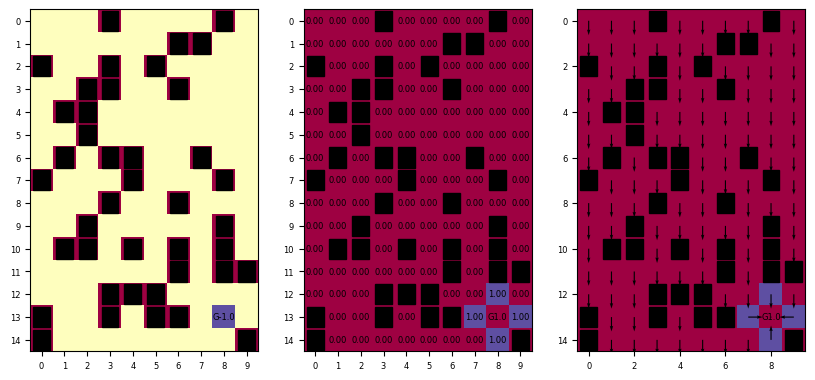

In [10]:
# Set Values to 0, do one update
Values = np.ones((15,10))*0
NewValues, Policy = update_values(Values, World, 0.95)

#Estimate change
err = np.sqrt(np.mean( (NewValues - Values)**2))
print('Distance between V_0(S) and V_1(S) is: {}'.format(err))

plot_world_values_policy(World, NewValues, Policy)

# Q: What happens? Why is the update such as this?


# To convergence.

Let's now perform many concurrent updates until a tolerance level or $\epsilon$ is reached:

$$
\delta V^2_k = 1/(L_X L_Y) \sum_S (V_{k+1}(S)-V_k(S) )^2 < \epsilon
$$

Distance between V_0(S) and V_1(S) is: 5.308483775994799
Distance between V_1(S) and V_2(S) is: 0.40470153611437293
Distance between V_2(S) and V_3(S) is: 0.38563837767179415
Distance between V_3(S) and V_4(S) is: 0.3674664081869711
Distance between V_4(S) and V_5(S) is: 0.34979428982550803
Distance between V_5(S) and V_6(S) is: 0.3329693845920229
Distance between V_6(S) and V_7(S) is: 0.31758028499059093
Distance between V_7(S) and V_8(S) is: 0.3028929462428181
Distance between V_8(S) and V_9(S) is: 0.2897188150985388
Distance between V_9(S) and V_10(S) is: 0.2776211719689289
Distance between V_10(S) and V_11(S) is: 0.2657406359276471
Distance between V_11(S) and V_12(S) is: 0.2543398999343624
Distance between V_12(S) and V_13(S) is: 0.24295821714947885
Distance between V_13(S) and V_14(S) is: 0.23228152146493722
Distance between V_14(S) and V_15(S) is: 0.22185842703090206
Distance between V_15(S) and V_16(S) is: 0.21189089681906068
Distance between V_16(S) and V_17(S) is: 0.202005956

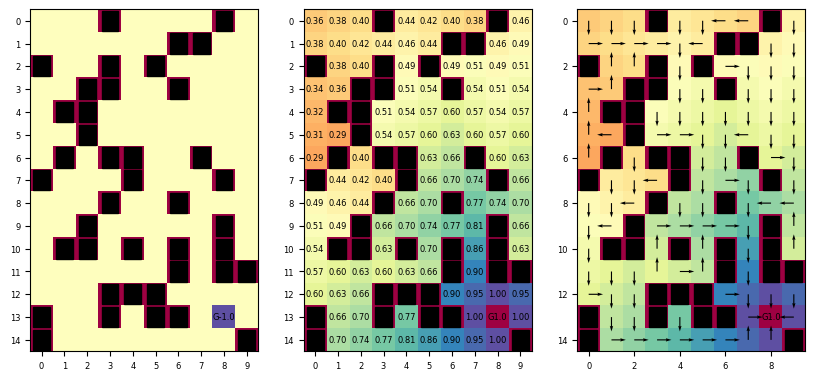

In [14]:
# Do iterative updates until err < tolerance
Values = np.ones((15,10))*10
NewValues = np.ones((15,10))*10

#plot_world_values(World, Values)

tol = 0.0001

for i in range(300):
    Values = NewValues
    
    # One Bellman Operator Update
    NewValues, Policy = update_values(Values, World, 0.95)

    #Estimate change
    err = np.sqrt(np.mean( (NewValues - Values)**2))
    print('Distance between V_{}(S) and V_{}(S) is: {}'.format(i, i+1, err))
    if err < tol:
        break

plot_world_values_policy(World, NewValues, Policy)


# Multiple Goals

__Q:__ If actions are deterministic, does a Goal with negative reward have any impact?

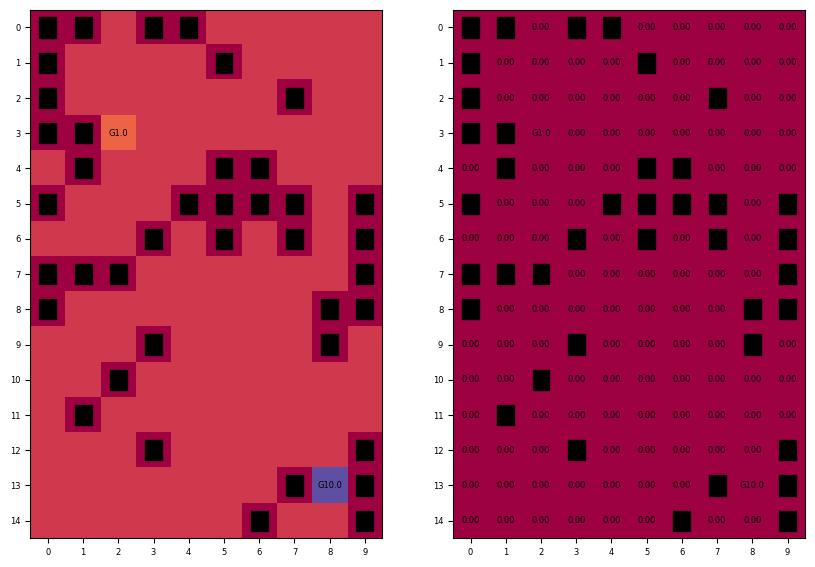

In [11]:
Lx = 10
Ly = 15
Nblocks=45

World_Two = new_world(Lx, Ly, Nblocks, [(13,8),(3,2)],[10,1])

Values_Two = np.zeros((15,10))
plot_world_values(World_Two, Values_Two)

Distance between V_14(S) and V_15(S) is: 0.0


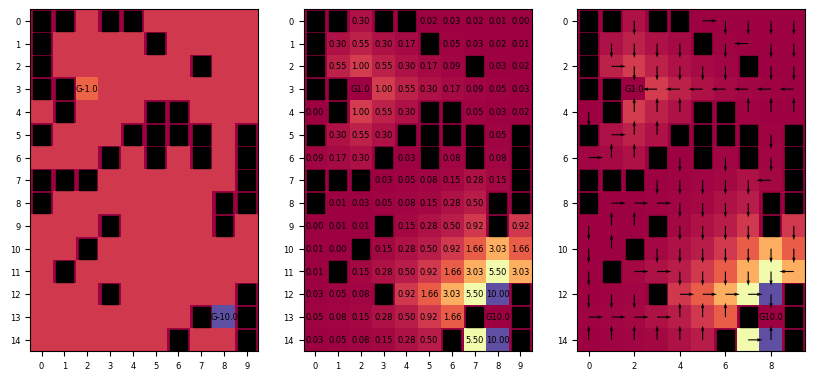

In [12]:
Values_Two = np.zeros((15,10))
tol = 0.0001

for i in range(80):
    OldValues_Two = Values_Two
    #Estimate change
    Values_Two, Policy_Two = update_values(Values_Two, World_Two, 0.55)
    err = np.sqrt(np.mean( (Values_Two - OldValues_Two)**2))
    if err < tol:
        print('Distance between V_{}(S) and V_{}(S) is: {}'.format(i, i+1, err))
        break
    
    
plot_world_values_policy(World_Two, Values_Two, Policy_Two)

#Q: What is the gamma for which the smallest goal becomes attractive?

# Stochastic Moves

Let us add some _noise_: When selecting an action A, the agent performs A correctly with probability $p$, or a _random_ action with probability $1-p$ (including A!).


In [13]:
def p_transition_random_wrapper(p=0.9):
    """
    Constructs a stochastic transition probability where you either do the action you chose with probability p 
    Or with probability (1-p) do a random action. 
    """
    def p_transition_random(S, A, World):
        # p   It actually does A
        # 1-p It does a random action

        # I move with chosen action with probability p
        S_new = S + A
        Ly, Lx = World.shape
        # if I go out of the world, I stay still
        if ((S_new[0] == Ly) or np.any(S_new == -1) or (S_new[1] == Lx)):
            S_new = S
        # if I found a block I stay still
        elif World[S_new[0],S_new[1]] == -1:
            S_new = S
        # returns the new state
        S_new_list = [S_new]
        P_list = [p]

        # I move randomly with all actions with probability (1-p) / #Actions
        for act in Actions:
            S_new = S + act
            Ly, Lx = World.shape
            # if I go out of the world, I stay still
            if ((S_new[0] == Ly) or np.any(S_new == -1) or (S_new[1] == Lx)):
                S_new = S
            # if I found a block I stay still
            elif World[S_new[0],S_new[1]] == -1:
                S_new = S
            # returns the new state
            S_new_list += [S_new]
            P_list += [(1-p)/len(Actions)]

        return S_new_list, P_list 
    return p_transition_random

# Introducing randomness


__Q:__ Does it change anything?

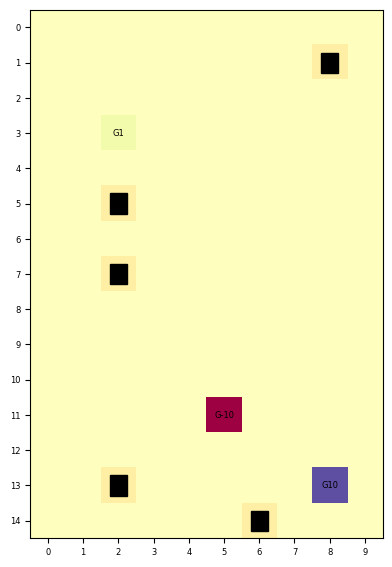

In [14]:
Lx = 10
Ly = 15
Nblocks=5

# Now we have three Terminal states and one has a large, negative Reward.

World_Three = new_world(Lx, Ly, Nblocks, [(13,8),(3,2),(11,5)],[10,1,-10])
plot_world(World_Three)

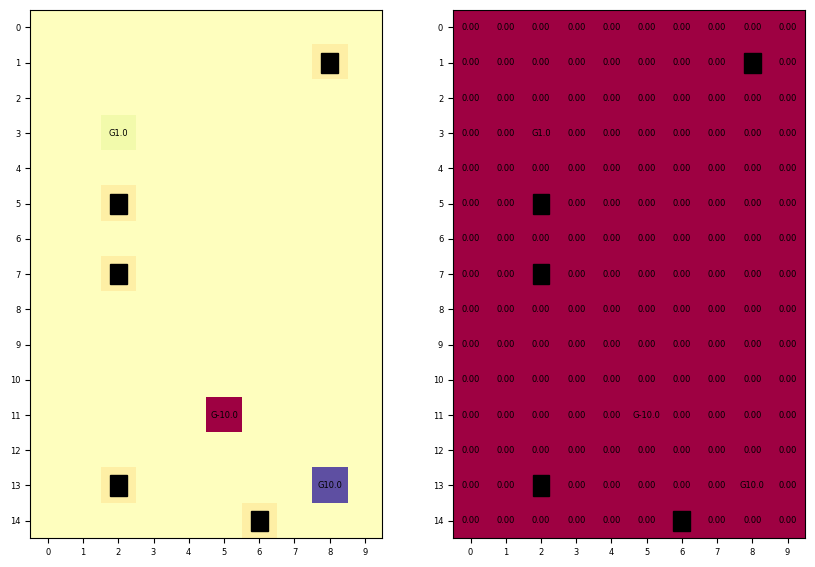

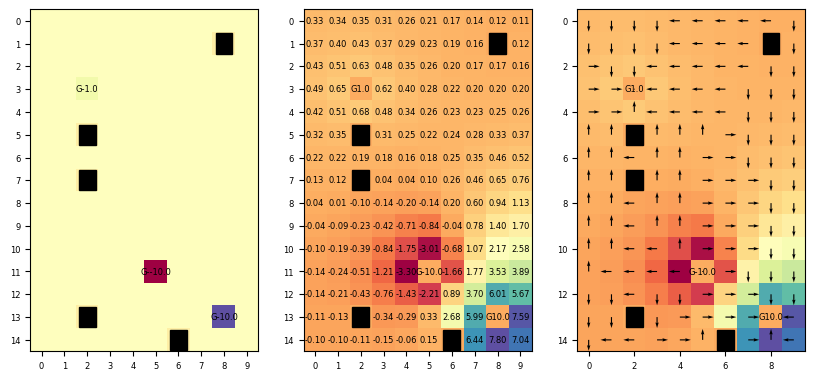

In [15]:
Values_Three = np.zeros((15,10))
plot_world_values(World_Three, Values_Three)

tol = 0.0000001
for i in range(80):
    Old_Values_Three = Values_Three
    Values_Three, Policy_Three = update_values(Values_Three, World_Three, 0.95, random_flag=True, p=0.1)
    #Estimate change
    err = np.mean( (Values_Three - Old_Values_Three)**2)
    #print('Distance between V_{}(S) and V_{}(S) is: {}'.format(i, i+1, err))
    if err < tol:
        break
    
plot_world_values_policy(World_Three, Values_Three, Policy_Three)

# ---- Plotting Utilities -----

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['font.size'] = 6

def plot_world(World):
    # ------------------
    Ly, Lx = World.shape

    fig, ax = plt.subplots()
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G{}'.format(int(World[j,i])), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                 text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass
    plt.show()
    # -------------------

    

def plot_world_values(World, Values):
    # ------------------
    Ly, Lx = World.shape

    fig, (ax, ax2) = plt.subplots(1,2)
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass

    im2 = ax2.imshow(Values, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax2.set_xticks(np.arange(Lx))
    ax2.set_yticks(np.arange(Ly))

    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j, goal[1]==i).any():
                text = ax2.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax2.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                text = ax2.text(i, j, '{:.2f}'.format(Values[j, i]), ha="center", va="center", color="black")
                
                
    plt.show()
    # -------------------

    

def plot_world_values_policy(World, Values, Policy):
    # ------------------
    Ly, Lx = World.shape

    fig, (ax, ax2, ax3) = plt.subplots(1,3)
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G-{}'.format(World[j,i]), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass

    im2 = ax2.imshow(Values, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax2.set_xticks(np.arange(Lx))
    ax2.set_yticks(np.arange(Ly))

    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j, goal[1]==i).any():
                text = ax2.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black")
                text = ax3.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax2.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
                text = ax3.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                text = ax2.text(i, j, '{:.2f}'.format(Values[j, i]), ha="center", va="center", color="black")
    
    im3 = ax3.imshow(Values, cmap=plt.get_cmap("Spectral"))
    X = np.arange(Lx)
    Y = np.arange(Ly)
    U, V = Policy[:,:,1], -Policy[:,:,0]
    q = ax3.quiver(X, Y, U, V, color="black")

    plt.show()
    # -------------------
    